In [1]:
import umap

import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.utils.class_weight import compute_sample_weight
from statsmodels.stats.outliers_influence import variance_inflation_factor

from linearmodels.panel import PanelOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("C:/Users/Настя/YandexDisk-n4skolesnikova/HSE 4th year/Graduation Thesis/data/PANEL_DATA_HYPOTHESIS.csv")
df = df.drop('Unnamed: 0', axis=1)
print(df.shape)
df.head()

(2985579, 65)


,REGION,road_name,YEAR_MONTH,n_ACCIDENTS,n_VEHICLES,n_PARTICIPANTS,n_DEATHS,n_INJURED,vehicle_age_min,vehicle_age_max,...,street_rank_cat,weather_cat,adj_objects_cat,cause_factors_cat,lighting_cat,site_objects_cat,severity,SEASON,WEEKDAY,is_toll
0,1,III Интернационал - Столбово - Ключи,2015-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,III Интернационал - Столбово - Ключи,2015-02,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,III Интернационал - Столбово - Ключи,2015-03,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,III Интернационал - Столбово - Ключи,2015-04,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,III Интернационал - Столбово - Ключи,2015-05,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.columns

Index(['REGION', 'road_name', 'YEAR_MONTH', 'n_ACCIDENTS', 'n_VEHICLES',
       'n_PARTICIPANTS', 'n_DEATHS', 'n_INJURED', 'vehicle_age_min',
       'vehicle_age_max', 'vehicle_age_avg', 'n_class_a', 'n_class_b',
       'n_class_c', 'n_class_d', 'n_class_e', 'n_class_s', 'n_front_drive',
       'n_rear_drive', 'n_4wd', 'n_guilty', 'guilty_share',
       'n_fatal_violations', 'guilty_exp_avg', 'exp_avg', 'vehicle_failure',
       'non_private_vehicle', 'white_vehicle', 'black_vehicle',
       'colored_vehicle', 'drunk_driver', 'female_driver', 'escaped',
       'no_seatbelt_injury', 'crossing_violation', 'impaired_driving',
       'interference_violation', 'license_violation', 'maneuver_violation',
       'other_violation', 'pedestrian_violation',
       'sudden_appearance_violation', 'traffic_control_violation',
       'transport_violation', 'vehicle_tech_violation', 'wrong_way',
       'out_of_town', 'is_WEEKEND', 'is_NIGHT', 'is_PEAK_HOUR',
       'road_rank_cat', 'road_defects_cat',

In [4]:
print(f"Final check for the gaps: {df.isna().any().sum()} gaps")

Final check for the gaps: 0 gaps


In [5]:
df_hypoth = df.copy()

### Hypothesis 1.1: 
#### «The average number of traffic accidents per month on toll roads is lower than on alternative free roads»


### Hypothesis 1.2: 
#### «The factors influencing the number of traffic accidents differ for toll and free roads»

----

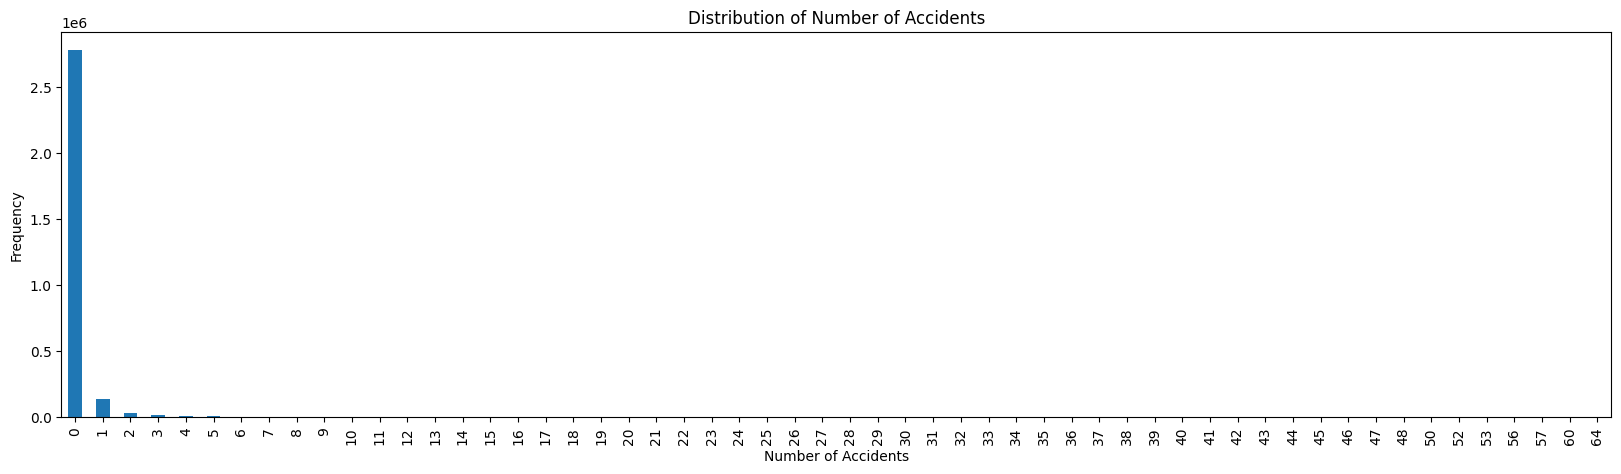

In [6]:
plt.figure(figsize=(20, 5))
df_hypoth['n_ACCIDENTS'].value_counts().sort_index().plot(kind='bar')

plt.title('Distribution of Number of Accidents')
plt.xlabel('Number of Accidents')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

plt.show()

# Econometrics

## Analysis of features

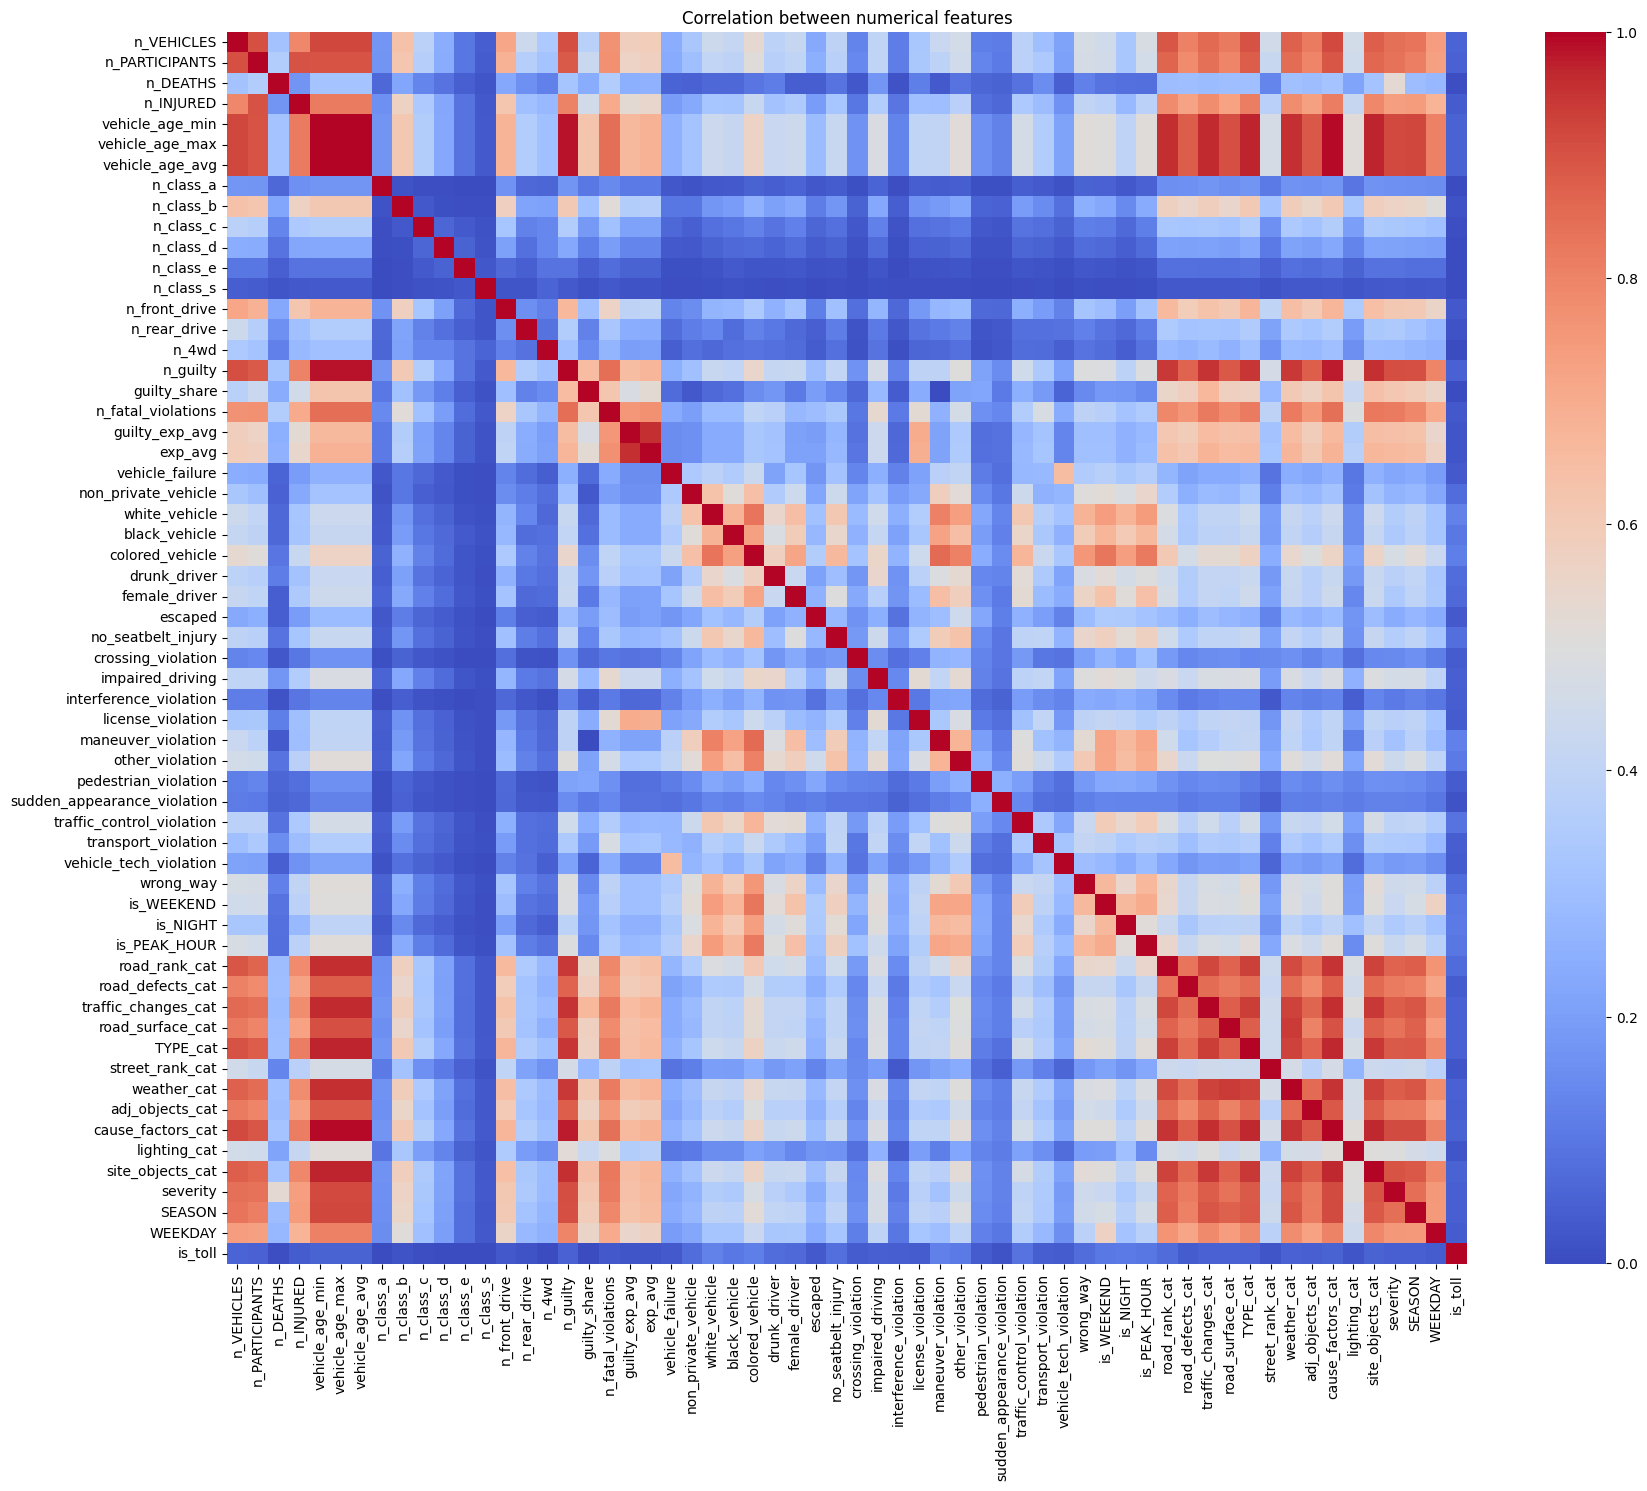

In [7]:
meaningful_df = df_hypoth.drop(['REGION', 'n_ACCIDENTS', 'out_of_town'], axis=1)
corr_matrix = meaningful_df.corr(numeric_only=True)

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between numerical features")
plt.show()

In [ ]:
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
corr_pairs = corr_matrix.where(upper)

high_corr = corr_pairs.stack().reset_index()
high_corr.columns = ['Feature1', 'Feature2', 'Correlation']

high_corr = high_corr[high_corr['Correlation'].abs() > 0.5]
high_corr = high_corr.reindex(high_corr['Correlation'].abs().sort_values(ascending=False).index)

print(high_corr)

# for f1, f2, f3 in high_corr[['Feature1', 'Feature2', 'Correlation']].values:
#     print(f"{f1} — {f2}: | {f3}")

vehicle_age_max — vehicle_age_avg: | 0.9999873987944383
vehicle_age_min — vehicle_age_avg: | 0.9999873632049258
vehicle_age_min — vehicle_age_max: | 0.9999496410514824
vehicle_age_max — cause_factors_cat: | 0.9944857035995748
vehicle_age_avg — cause_factors_cat: | 0.9944762216958444
vehicle_age_min — cause_factors_cat: | 0.994441574134848
vehicle_age_max — n_guilty: | 0.9857576739631043
vehicle_age_avg — n_guilty: | 0.9857460455969832
vehicle_age_min — n_guilty: | 0.985709910125985
n_guilty — cause_factors_cat: | 0.9804256855975082
vehicle_age_min — site_objects_cat: | 0.9700956872660259
vehicle_age_avg — site_objects_cat: | 0.9700853003355716
vehicle_age_max — site_objects_cat: | 0.9700458517477978
vehicle_age_max — TYPE_cat: | 0.9691258268909138
vehicle_age_avg — TYPE_cat: | 0.9690995209611494
vehicle_age_min — TYPE_cat: | 0.9690523501223124
TYPE_cat — cause_factors_cat: | 0.966119411674991
cause_factors_cat — site_objects_cat: | 0.9656421637217725
vehicle_age_min — traffic_changes_c

In [ ]:
features_to_drop = [
    'vehicle_age_min',
    'vehicle_age_max',
    'vehicle_age_avg',
    'guilty_exp_avg',
    'n_guilty',
    'traffic_changes_cat',
    'n_PARTICIPANTS',
    'n_INJURED',
    'weather_cat',
    'cause_factors_cat',
    'site_objects_cat',
    'severity',
    'colored_vehicle'
]

df_hypoth.drop(features_to_drop, axis=1, inplace=True)

Для полноценного анализа не будем исключать переменные из рассмотрения, но будем полагаться на анализ при интерпретации признаков при проверке гипотез.

In [10]:
meaningful_df = df_hypoth.drop(['REGION', 'n_ACCIDENTS', 'out_of_town'], axis=1)
meaningful_df = meaningful_df.select_dtypes(include=['int64', 'float64'])

vif = pd.DataFrame()
vif["feature"] = meaningful_df.columns
vif["VIF"] = [variance_inflation_factor(meaningful_df.values, i) for i in range(meaningful_df.shape[1])]

C:\Users\Настя\AppData\Local\Temp\ipykernel_20864\3810041898.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


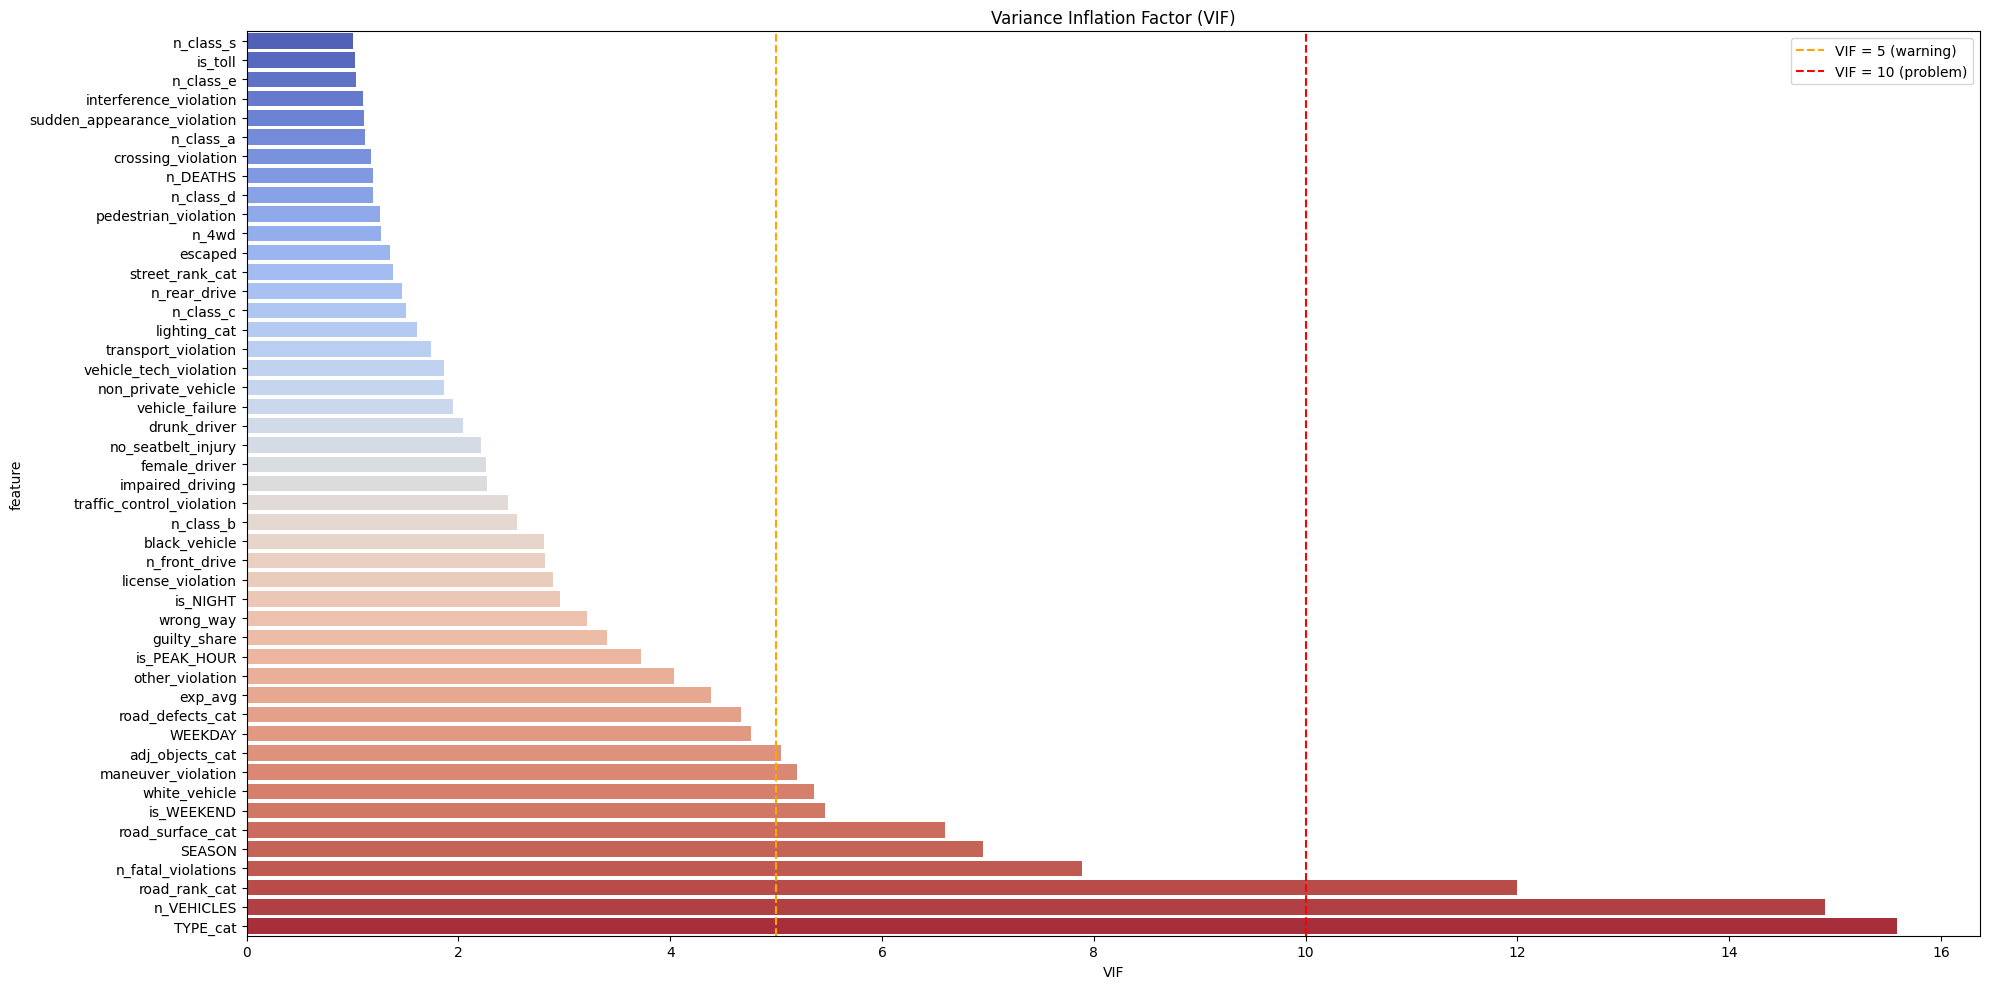

In [11]:
plt.figure(figsize=(20, 10))
sns.barplot(
    data=vif.sort_values(by="VIF", ascending=True),
    x="VIF",
    y="feature",
    palette="coolwarm"
)
plt.axvline(5, color='orange', linestyle='--', label='VIF = 5 (warning)')
plt.axvline(10, color='red', linestyle='--', label='VIF = 10 (problem)')
plt.title("Variance Inflation Factor (VIF)")
plt.xlabel("VIF")
plt.ylabel("feature")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# high_vif_features = vif[vif["VIF"] > 10]['feature'].to_list()
# df_hypoth.drop(columns=high_vif_features, axis=1, inplace=True)

# print(f"Num of features before the analysis: {df.shape[1]}")
# print(f"Num of features after: {df_hypoth.shape[1]}")

Num of features before the analysis: 65
Num of features after: 49


## Fixed Effects Panel Regression, FE

«The average number of traffic accidents per month on toll roads is lower than on alternative free roads»,
можно сформулировать несколько спецификаций модели панельной регрессии с фиксированными эффектами, последовательно усложняя модель и проверяя устойчивость результатов.



**1. Базовая модель (`n_ACCIDENTS ~ is_toll`)**  
Начальная спецификация включает только переменную `is_toll`, чтобы оценить её прямое влияние на количество аварий без учета прочих факторов. Эта простая модель позволяет зафиксировать "сырое" различие между платными и бесплатными дорогами. Несмотря на потенциальную смещенность из-за пропущенных переменных, она служит важной отправной точкой для анализа гипотезы.

**2. Модель с временными характеристиками (`+ SEASON + is_WEEKEND + is_NIGHT + is_PEAK_HOUR + WEEKDAY`)**  
Во вторую спецификацию добавлены временные предикторы: сезон, день недели, выходной/рабочий день, время суток и час пик. Эти переменные позволяют учесть сезонные и поведенческие паттерны аварийности, связанные с календарем и режимом движения. Контроль за ними позволяет изолировать влияние `is_toll` от циклических факторов.

**3. Модель с характеристиками транспортных средств и водителей (`+ drunk_driver + female_driver + escaped + no_seatbelt_injury + exp_avg + guilty_share`)**  
Третья модель расширяется за счёт поведенческих и технических характеристик участников ДТП. Эти факторы прямо связаны с вероятностью аварий и могут быть неодинаково представлены на разных типах дорог. Контроль за ними позволяет исключить возможность того, что связь между `is_toll` и количеством аварий обусловлена особенностями водителей.

**4. Модель инфраструктуры и условий дороги (`+ road_defects_cat + road_surface_cat + street_rank_cat + adj_objects_cat + lighting_cat + out_of_town`)**  
Четвертая спецификация включает переменные, описывающие физическую инфраструктуру и условия окружающей среды на дорогах. Эти характеристики необходимы для учета различий между платными и бесплатными дорогами, таких как качество покрытия, освещение, расположенность за пределами города и наличие объектов рядом с дорогой.

**5. Полная модель (все контрольные переменные)**  
Пятая модель объединяет все вышеуказанные блоки предикторов и представляет собой наиболее полную спецификацию. Она позволяет оценить устойчивость эффекта `is_toll` при одновременном контроле временных, поведенческих и инфраструктурных факторов. Если `is_toll` сохраняет значимость в этой модели, это указывает на наличие независимого влияния платности дороги на аварийность и подтверждает гипотезу о различиях между платными и бесплатными дорогами.

In [15]:
toll_roads_percent = ((df_hypoth['is_toll'] == 1).sum() / df_hypoth.shape[0]) * 100
print(f"Percent of obs on toll roads (with negative sampling): {round(toll_roads_percent, 2)}%\n")

df_accidents = df_hypoth[df_hypoth['n_ACCIDENTS'] > 0]
toll_accidents_percent = ((df_accidents['is_toll'] == 1).sum() / df_accidents.shape[0]) * 100
print(f"Percent of accidents on toll roads (without negative sampling): {round(toll_accidents_percent, 2)}%")

Percent of obs on toll roads (with negative sampling): 0.63%

Percent of accidents on toll roads (without negative sampling): 2.09%


Due to the imbalance we'll test the hypothesis two ways:

0. Without balancing
1. Balancing using class weighting

In [16]:
df_hypoth_copy = df_hypoth.copy()

In [17]:
# preparing dataset
df_hypoth_copy['region_road'] = df_hypoth_copy['REGION'].astype(str) + "_" + df_hypoth_copy['road_name'].astype(str)
df_hypoth_copy['YEAR_MONTH'] = pd.to_datetime(df_hypoth_copy['YEAR_MONTH'])
df_hypoth_copy = df_hypoth_copy.set_index(['region_road', 'YEAR_MONTH'])

In [ ]:
from linearmodels.panel import PooledOLS
import statsmodels.api as sm

X1 = sm.add_constant(df_hypoth_copy[['is_toll']])
y = df_hypoth_copy['n_ACCIDENTS']

model1 = PooledOLS(y, X1)
res1 = model1.fit()

print('\n1. Base model:')
print(res1.summary)


1. Base model:
                          PooledOLS Estimation Summary                          
Dep. Variable:            n_ACCIDENTS   R-squared:                        0.0152
Estimator:                  PooledOLS   R-squared (Between):              0.0249
No. Observations:             2985579   R-squared (Within):               0.0000
Date:                Fri, May 02 2025   R-squared (Overall):              0.0152
Time:                        01:19:49   Log-likelihood                -3.973e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   4.607e+04
Entities:                       24273   P-value                           0.0000
Avg Obs:                       123.00   Distribution:               F(1,2985577)
Min Obs:                       123.00                                           
Max Obs:                       123.00   F-statistic (robust):          4.607e+04
            

In [19]:
X2 = sm.add_constant(df_hypoth_copy[['is_toll', 'SEASON', 'is_WEEKEND', 'is_NIGHT', 'is_PEAK_HOUR', 'WEEKDAY']])
y = df_hypoth_copy['n_ACCIDENTS']

model2 = PooledOLS(y, X2)
res2 = model2.fit()

print('\n2. :')
print(res2.summary)


2. :
                          PooledOLS Estimation Summary                          
Dep. Variable:            n_ACCIDENTS   R-squared:                        0.9075
Estimator:                  PooledOLS   R-squared (Between):              0.9874
No. Observations:             2985579   R-squared (Within):               0.7826
Date:                Fri, May 02 2025   R-squared (Overall):              0.9075
Time:                        01:20:11   Log-likelihood                -4.428e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   4.879e+06
Entities:                       24273   P-value                           0.0000
Avg Obs:                       123.00   Distribution:               F(6,2985572)
Min Obs:                       123.00                                           
Max Obs:                       123.00   F-statistic (robust):          4.879e+06
                      

In [20]:
X3 = sm.add_constant(df_hypoth_copy[['is_toll', 'drunk_driver', 'female_driver', 'escaped',
                               'no_seatbelt_injury', 'exp_avg', 'guilty_share']])
y = df_hypoth_copy['n_ACCIDENTS']

model3 = PooledOLS(y, X3)
res3 = model3.fit()

print('\n3. :')
print(res3.summary)


3. :
                          PooledOLS Estimation Summary                          
Dep. Variable:            n_ACCIDENTS   R-squared:                        0.7653
Estimator:                  PooledOLS   R-squared (Between):              0.9210
No. Observations:             2985579   R-squared (Within):               0.5221
Date:                Fri, May 02 2025   R-squared (Overall):              0.7653
Time:                        01:20:39   Log-likelihood                -1.832e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.391e+06
Entities:                       24273   P-value                           0.0000
Avg Obs:                       123.00   Distribution:               F(7,2985571)
Min Obs:                       123.00                                           
Max Obs:                       123.00   F-statistic (robust):          1.391e+06
                      

In [21]:
X4 = sm.add_constant(df_hypoth_copy[['is_toll', 'road_defects_cat', 'road_surface_cat',
                               'street_rank_cat', 'adj_objects_cat', 'lighting_cat', 'out_of_town']])
y = df_hypoth_copy['n_ACCIDENTS']

model4 = PooledOLS(y, X4)
res4 = model4.fit()

print('\n4. :')
print(res4.summary)


4. :
                          PooledOLS Estimation Summary                          
Dep. Variable:            n_ACCIDENTS   R-squared:                        1.0000
Estimator:                  PooledOLS   R-squared (Between):              1.0000
No. Observations:             2985579   R-squared (Within):               1.0000
Date:                Fri, May 02 2025   R-squared (Overall):              1.0000
Time:                        01:21:19   Log-likelihood                 7.171e+07
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   4.508e+27
Entities:                       24273   P-value                           0.0000
Avg Obs:                       123.00   Distribution:               F(7,2985571)
Min Obs:                       123.00                                           
Max Obs:                       123.00   F-statistic (robust):          4.508e+27
                      

In [22]:
X5 = sm.add_constant(df_hypoth_copy[['is_toll', 'SEASON', 'is_WEEKEND', 'is_NIGHT', 'is_PEAK_HOUR', 'WEEKDAY',
                               'drunk_driver', 'female_driver', 'escaped', 'no_seatbelt_injury', 'exp_avg', 'guilty_share',
                               'road_defects_cat', 'road_surface_cat', 'street_rank_cat', 'adj_objects_cat',
                               'lighting_cat', 'out_of_town']])
y = df_hypoth_copy['n_ACCIDENTS']

model5 = PooledOLS(y, X5)
res5 = model5.fit()

print('\n5. :')
print(res5.summary)


5. :
                          PooledOLS Estimation Summary                          
Dep. Variable:            n_ACCIDENTS   R-squared:                        1.0000
Estimator:                  PooledOLS   R-squared (Between):              1.0000
No. Observations:             2985579   R-squared (Within):               1.0000
Date:                Fri, May 02 2025   R-squared (Overall):              1.0000
Time:                        01:21:59   Log-likelihood                 7.306e+07
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   4.348e+27
Entities:                       24273   P-value                           0.0000
Avg Obs:                       123.00   Distribution:              F(18,2985560)
Min Obs:                       123.00                                           
Max Obs:                       123.00   F-statistic (robust):          4.348e+27
                      

In [25]:
sample_weights = compute_sample_weight(class_weight='balanced', y=df_hypoth['is_toll'])
df_weighted = df_hypoth.loc[df_hypoth.index.repeat(sample_weights.round().astype(int))]

df_weighted['region_road'] = df_weighted['REGION'].astype(str) + "_" + df_weighted['road_name'].astype(str)
df_weighted['YEAR_MONTH'] = pd.to_datetime(df_weighted['YEAR_MONTH'])
df_weighted = df_weighted.set_index(['region_road', 'YEAR_MONTH'])

In [26]:
X4 = sm.add_constant(df_weighted[['is_toll', 'road_defects_cat', 'road_surface_cat',
                               'street_rank_cat', 'adj_objects_cat', 'lighting_cat', 'out_of_town']])
y = df_weighted['n_ACCIDENTS']

model4 = PooledOLS(y, X4)
res4 = model4.fit()

print('\n4. :')
print(res4.summary)


4. :
                          PooledOLS Estimation Summary                          
Dep. Variable:            n_ACCIDENTS   R-squared:                        1.0000
Estimator:                  PooledOLS   R-squared (Between):              1.0000
No. Observations:             4462563   R-squared (Within):               1.0000
Date:                Fri, May 02 2025   R-squared (Overall):              1.0000
Time:                        01:46:59   Log-likelihood                 1.449e+08
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.402e+36
Entities:                       24273   P-value                           0.0000
Avg Obs:                       183.85   Distribution:               F(7,4462555)
Min Obs:                       123.00                                           
Max Obs:                       9840.0   F-statistic (robust):          1.402e+36
                      